In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Подрубим Google-Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!ls 'gdrive/My Drive/Colab Notebooks/CycleGAN/'

CycleGAN.ipynb	Dataset  Evolve  Evolve.png  models


In [0]:
!cd 'gdrive/My Drive/Colab Notebooks/CycleGAN/'

In [0]:
path = 'gdrive/My Drive/Colab Notebooks/CycleGAN/'

## Создадим наиболее используемую вещь в современных сетях:
Класс генерирующий блок с остаточной связью. Так как я ленив он будет без понижения размерности.

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()

    conv_block = [ nn.ReflectionPad2d(1), 
                   nn.Conv2d(in_features, in_features, kernel_size=3),
                   nn.InstanceNorm2d(in_features),
                   nn.ELU(inplace=True),
                   nn.ReflectionPad2d(1),
                   nn.Conv2d(in_features, in_features, 3),
                   nn.InstanceNorm2d(in_features) ]

    self.conv_block = nn.Sequential(*conv_block)

    self.act_res = nn.SELU(inplace=True)

  def forward(self, x):
    return self.act_res( x + self.conv_block(x) )

## Создадим класс генератора
Шагом в конволюции будем управлять уменьшением размерности.

Последняя функция активации гиперболический тангенс для превращения в картинку.

In [0]:
class Generator(nn.Module):
  def __init__(self, input_nc, output_nc, n_res_blocks=9):
    super(Generator, self).__init__()

    # Initial convolution block
    model = [ ResidualBlock(input_nc),
              nn.ReflectionPad2d(1),
              nn.Conv2d(input_nc, 64, 3),
              nn.InstanceNorm2d(64),
              nn.ELU(inplace=True) ]

    # Downsampling 
    in_features = 64
    out_features = in_features * 2
    for _ in range(3):
      model += [ nn.Conv2d(in_features, out_features, kernel_size=3,
                           stride=2, padding=1),
                 nn.InstanceNorm2d(out_features),
                 nn.ELU(inplace=True) ]
      in_features = out_features
      out_features = in_features * 2

    # Residual blocks
    for _ in range(n_res_blocks):
      model += [ ResidualBlock(in_features) ]

    # Upsampling
    out_features = in_features // 2
    for _ in range(3):
      model += [ nn.ConvTranspose2d(in_features, out_features, kernel_size=3,
                                    stride=2, padding=1, output_padding=1),
                 nn.InstanceNorm2d(out_features),
                 nn.ELU(inplace=True) ]
      in_features = out_features
      out_features = in_features // 2

    # Output layers
    model += [ ResidualBlock(in_features),
               nn.ReflectionPad2d(1),
               nn.Conv2d(64, output_nc, 3),
               nn.Tanh()]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)


## Создадим ленивый классификатор

In [0]:
class Discriminator(nn.Module):
  def __init__(self, input_nc, n_res_blocks=9):
    super(Discriminator, self).__init__()

    # Input layers
    model = [ nn.Conv2d(input_nc, 128, kernel_size=4, stride=2, padding=1),
              nn.LeakyReLU(0.2, inplace=True) ]

    # Something like ResNet
    in_features = 128
    for _ in range(n_res_blocks):
      model += [ ResidualBlock(in_features) ]

    # FCN classification layer
    model += [ nn.Conv2d(in_features, 1, kernel_size=4, padding=1) ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    x = self.model(x)
    # Average pooling and flatten
    return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
    

### В результате работы пришел к выводу, что стоит сначала имплементировать то что описано в статье.

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

## Создадим обьект с параметрами
Если заменить parser.parse_known_args() на parser.parse_args() можно передавать набор аргументов, но возможно это только из командной строки.
Удобно все переменные вызывать из одного обьекта и менять в нем.

In [0]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs of training')
parser.add_argument('--batch_size', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default=path+'Dataset/horse2zebra/', help='root directory of the dataset')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=40, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=256, help='size of the data crop (squared assumed)')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--cuda', action='store_true', help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
opt = parser.parse_known_args()[0]
print(opt)

Namespace(batch_size=1, cuda=False, dataroot='gdrive/My Drive/Colab Notebooks/CycleGAN/Dataset/horse2zebra/', decay_epoch=40, epoch=0, input_nc=3, lr=0.0002, n_cpu=8, n_epochs=200, output_nc=3, size=256)


### Проверим доступна ли нам CUDA

In [0]:
opt.cuda

False

In [0]:
if torch.cuda.is_available() and not opt.cuda:
  opt.cuda = True                              

In [0]:
opt.batch_size = 1

## Обьявим переменные
### Сначала обьявим сети и веса для них

In [0]:
# Networks
Gen_X2Y = Generator(opt.input_nc, opt.output_nc)
Gen_Y2X = Generator(opt.output_nc, opt.input_nc)
Discr_X = Discriminator(opt.input_nc)
Discr_Y = Discriminator(opt.output_nc)

if opt.cuda:
  Gen_X2Y.cuda()
  Gen_Y2X.cuda()
  Discr_X.cuda()
  Discr_Y.cuda()

# Weight-initialization of Networks
def weights_inint(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal(m.weight.data, 0.0, 0.02)
    
  elif classname.find('BatchNorm2d') != -1:
    nn.init.normal(m.weight.data, 1.0, 0.02)
    nn.init.constant(m.bias.data, 0.0)

Gen_X2Y.apply(weights_inint)
Gen_Y2X.apply(weights_inint)
Discr_X.apply(weights_inint)
Discr_Y.apply(weights_inint)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  app.launch_new_instance()


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### Обьявим функции потерь
Least Squares GAN

In [0]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

### Обьявим оптимизаторы и стратегии пониженя LR

In [0]:
import itertools

In [0]:
retrain_models = False
if retrain_models:
  Gen_X2Y.load_state_dict(torch.load(path + 'models/Gen_X2Y1.pth'))
  Gen_Y2X.load_state_dict(torch.load(path + 'models/Gen_Y2X1.pth'))
  Discr_X.load_state_dict(torch.load(path + 'models/Discr_X1.pth'))
  Discr_Y.load_state_dict(torch.load(path + 'models/Discr_Y1.pth'))

In [0]:
# Optimizers and LR schedulers
optimizer_G_X = torch.optim.Adam(Gen_X2Y.parameters(), 
                                 lr=opt.lr, betas=(0.5, 0.999))

optimizer_G_Y = torch.optim.Adam(Gen_Y2X.parameters(),
                                 lr=opt.lr, betas=(0.5, 0.999))

optimizer_D_X = torch.optim.Adam(Discr_X.parameters(),
                                 lr=opt.lr,
                                 betas=(0.5, 0.999))

optimizer_D_Y = torch.optim.Adam(Discr_Y.parameters(),
                                 lr=opt.lr,
                                 betas=(0.5, 0.999))

class LambdaLR():
  def __init__(self, n_epochs, offset, decay_start_epoch):
    assert ((n_epochs - decay_start_epoch) > 0) , 'Decay must start before the training session ends!'
    self.n_epochs = n_epochs
    self.offset = offset
    self.decay_start_epoch = decay_start_epoch

  def step(self, epoch):
    return 1. - max(0, epoch + self.offset - self.decay_start_epoch) / \
    (self.n_epochs - self.decay_start_epoch)

lr_scheduler_G_X = torch.optim.lr_scheduler.LambdaLR(optimizer_G_X, 
  lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

lr_scheduler_G_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_G_Y, 
  lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, 
  lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, 
  lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

### Определим плесходлеры для картинок

Таргеты реальный и ложный нужны для того что бы потом считать MSE между ответом дискриминатора и реальным значением.

In [0]:
from torch.autograd import Variable

In [0]:
tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_X = tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_Y = tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)

target_real = Variable(tensor(opt.batch_size).fill_(1.), 
                       requires_grad=False)
target_fake = Variable(tensor(opt.batch_size).fill_(0.),
                       requires_grad=False)

### Напишем ReplayBuffer для уменьшения осциляций лосса

In [0]:
import random

In [0]:
class ReplayBuffer():
  def __init__(self, max_size=50):
    assert (max_size > 0), 'Empty buffer or trying to create black hole'
    self.max_size = max_size
    self.data = []

  def push_and_pop(self, data):
    to_return = []
    for element in data.data:
      element = torch.unsqueeze(element, 0)
      
      if len(self.data) < self.max_size:
        self.data.append(element)
        to_return.append(element)

      else:
        if random.uniform(0, 1) > 0.5:
          i = random.randint(0, self.max_size-1)
          to_return.append(self.data[i].clone())
          self.data[i] = element

        else:
          to_return.append(element)
    return Variable(torch.cat(to_return))


In [0]:
fake_X_buffer = ReplayBuffer()
fake_Y_buffer = ReplayBuffer()

### Определим препроцессинг и загрузчик данных

In [0]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

In [0]:
transforms_ = [ transforms.Resize(int(opt.size * 1.12), Image.BICUBIC),
                transforms.RandomCrop(opt.size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ]

In [0]:
import glob
import os
import cv2
from torch.utils.data import Dataset

In [0]:
class ImageDataset(Dataset):
  def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
    self.transform = transforms.Compose(transforms_)
    self.unaligned = unaligned

    self.files_X = sorted(glob.glob(os.path.join(root, mode + 'Y') + 
                                    '/*.*'))
    self.files_Y = sorted(glob.glob(os.path.join(root, mode + 'X') + 
                                    '/*.*'))
    
  def __getitem__(self, index):
    image_X = Image.open(self.files_X[index % len(self.files_X)]).convert('RGB')
    item_X = self.transform(image_X)
    
    if self.unaligned:
      image_Y = Image.open(self.files_Y[random.randint(0, len(self.files_Y) - 1)]).convert('RGB')
      item_Y = self.transform(image_Y)
    else:
      image_Y = Image.open(self.files_Y[index % len(self.files_Y)]).convert('RGB')
      item_Y = self.transform(image_Y)
    return {'X': item_X, 'Y': item_Y}
      
  def __len__(self):
    return max(len(self.files_X), len(self.files_Y))

In [0]:
dataloader = DataLoader(ImageDataset(opt.dataroot,
                                     transforms_=transforms_, 
                                     unaligned=True,),
                        batch_size=opt.batch_size, shuffle=True, 
                        num_workers=opt.n_cpu)

### Проиллюстрируем работу даталоудера на примере 308 картинки в домене зебр

In [0]:
img = Image.open(dataloader.dataset.files_X[308]).convert('RGB')
img = transforms.ToPILImage()(transforms.Compose(transforms_)(img))

In [0]:
img

In [0]:
len(dataloader.dataset.files_X)

1334

In [0]:
len(dataloader.dataset.files_Y)

1067

### Напишем функции для работы с переводом изображений из тензора в формат RGB

In [0]:
import time
import datetime
import sys

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

unloader = transforms.ToPILImage()  # reconvert into PIL image

def tensor2image(tensor):
    tensor = tensor.view(tensor.shape[2], tensor.shape[3], tensor.shape[1])
    image = (127.5*(tensor.cpu().float() + 1.0)).numpy().astype('uint8')
    return image

### Напишем логирование обучения

In [0]:
class Logger():
    def __init__(self, n_epochs, batches_epoch):
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_hist = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' %
                         (self.epoch, self.n_epochs, 
                          self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = list()
                self.loss_hist[loss_name] = list()
                self.losses[loss_name].append(losses[loss_name].data.cpu())
                self.loss_hist[loss_name].append(losses[loss_name].data.cpu())

            else:
                self.losses[loss_name].append(losses[loss_name].data.cpu())
                self.loss_hist[loss_name].append(losses[loss_name].data.cpu())

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % 
                                 (loss_name, np.mean(self.losses[loss_name])))
            else:
                sys.stdout.write('%s: %.4f | ' %
                                 (loss_name, np.mean(self.losses[loss_name])))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + \
                        self.batches_epoch - self.batch 
        sys.stdout.write('ETA: %s' % 
                         (datetime.timedelta(seconds=batches_left*
                                             self.mean_period/batches_done)))
        if self.batch == 1:
            # Draw images
            for image_name, tensor in images.items():
                
                plt.ion()
                plt.figure()
                # imshow(tensor.data, title=image_name)
                plt.imshow(tensor2image(tensor.data))
                plt.title(image_name)
                plt.show()
                plt.ioff()

            # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                plt.plot(loss)
                plt.xlabel('epochs')
                plt.ylabel(loss_name)
                plt.title(loss_name)
                plt.show()
                self.losses[loss_name] = []

            self.epoch += 1
            self.batch  = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

In [0]:
# Loss plot
logger = Logger(opt.n_epochs, len(dataloader))

### Загрузка выгрузка обьектов

In [0]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Обучение


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 004/200 [1334/1334] -- loss_G: 5.7668 | loss_G_identity: 1.6525 | loss_G_GAN: 0.4488 | loss_G_cycle: 3.6655 | loss_D: 0.2288 -- ETA: 2 days, 6:51:51.563965

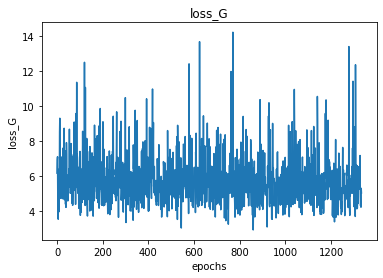

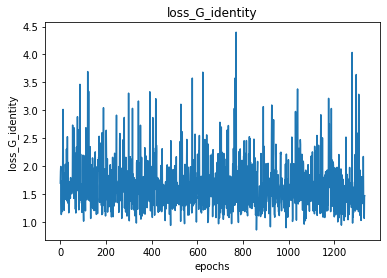

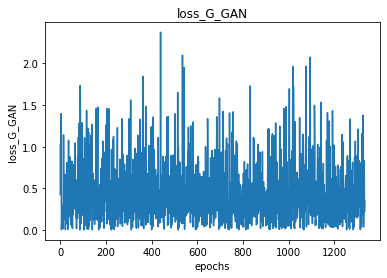

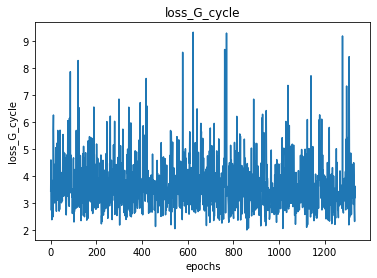

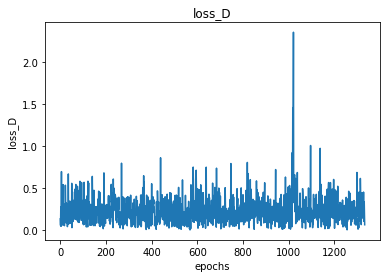


Epoch 005/200 [0001/1334] -- loss_G: 4.2131 | loss_G_identity: 1.2231 | loss_G_GAN: 0.4649 | loss_G_cycle: 2.5251 | loss_D: 0.3516 -- ETA: 2 days, 6:52:28.990977

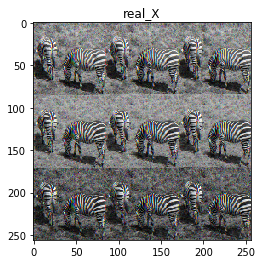

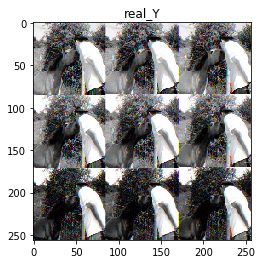

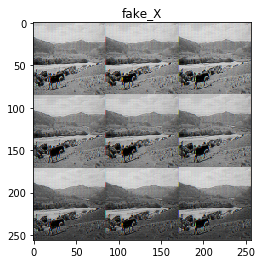

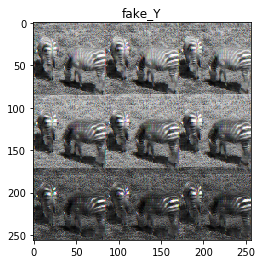

Epoch 005/200 [0061/1334] -- loss_G: 5.3728 | loss_G_identity: 1.5421 | loss_G_GAN: 0.4489 | loss_G_cycle: 3.3818 | loss_D: 0.2155 -- ETA: 2 days, 6:49:56.529336

In [0]:
for epoch in range(opt.epoch, opt.n_epochs):
  for i, batch in enumerate(dataloader):
    # Set model input
    real_X = Variable(input_X.copy_(batch['X']))
    real_Y = Variable(input_Y.copy_(batch['Y']))

    ### Generators X2Y and Y2X ###
    optimizer_G_X.zero_grad()
    optimizer_G_Y.zero_grad()


    # Identity loss
    # Gen_X2Y(Y) should be equal Y if real Y is fed
    same_Y = Gen_X2Y(real_Y)
    loss_identity_Y = criterion_identity(same_Y, real_Y) * 5.
    # Gen_Y2X(X) should be equal X if real X is fed
    same_X = Gen_Y2X(real_X)
    loss_identity_X = criterion_identity(same_X, real_X) * 5. 

    # GAN loss
    fake_Y = Gen_X2Y(real_X)
    pred_fake = Discr_Y(fake_Y)
    loss_GAN_X2Y = criterion_GAN(pred_fake, target_real)

    fake_X = Gen_Y2X(real_Y)
    pred_fake = Discr_X(fake_X)
    loss_GAN_Y2X = criterion_GAN(pred_fake, target_fake)

    # Cycle loss
    recovered_X = Gen_Y2X(fake_Y)
    loss_cycle_XYX = criterion_cycle(recovered_X, real_X) * 10

    recovered_Y = Gen_X2Y(fake_X)
    loss_cycle_YXY = criterion_cycle(recovered_Y, real_Y) * 10

    # Total loss
    loss_G = loss_identity_X + loss_identity_Y + loss_GAN_X2Y + \
              loss_GAN_Y2X + loss_cycle_XYX + loss_cycle_YXY

    loss_G.backward()

    optimizer_G_X.step()
    optimizer_G_Y.step()

    ### Discriminator X ###
    optimizer_D_X.zero_grad()

    # Real loss
    pred_real = Discr_X(real_X)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_X = fake_X_buffer.push_and_pop(fake_X)
    pred_fake = Discr_X(fake_X.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_X = (loss_D_real + loss_D_fake) * 0.5
    loss_D_X.backward()

    optimizer_D_X.step()

    ### Discriminator Y ###
    optimizer_D_Y.zero_grad()
    
    # Real loss
    pred_real = Discr_Y(real_Y)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_Y = fake_Y_buffer.push_and_pop(fake_Y)
    pred_fake = Discr_Y(fake_Y.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_Y = (loss_D_real + loss_D_fake) * 0.5
    loss_D_Y.backward()

    optimizer_D_Y.step()

    logger.log({'loss_G': loss_G, 
                'loss_G_identity': (loss_identity_X + loss_identity_Y), 
                'loss_G_GAN': (loss_GAN_X2Y + loss_GAN_Y2X),
                'loss_G_cycle': (loss_cycle_XYX + loss_cycle_YXY),
                'loss_D': (loss_D_X + loss_D_Y)}, 
                    images={'real_X': real_X, 
                            'real_Y': real_Y, 
                            'fake_X': fake_X,
                            'fake_Y': fake_Y})
    # cv2.imwrite(tensor2image(Gen_Y2X()))

  # Update learning rates
  lr_scheduler_G_X.step()
  lr_scheduler_G_Y.step()
  lr_scheduler_D_X.step()
  lr_scheduler_D_Y.step()

  torch.save(Gen_X2Y.state_dict(), path + 'models/Gen_X2Y2.pth')
  torch.save(Gen_Y2X.state_dict(), path + 'models/Gen_Y2X2.pth')
  torch.save(Discr_X.state_dict(), path + 'models/Discr_X2.pth')
  torch.save(Discr_Y.state_dict(), path + 'models/Discr_Y2.pth')

  save_obj(logger.loss_hist, path + 'models/losses2')

### К сожалению попыток обучить было слишком много и каждая занимала больше положенного из-за чего колаб отобрал у меня ГПУ я так и не дообучил, но на последней картинке видно что модель уже начала пытаться менять зебру в обычную лошадь. Вопрос с тем на сколько задача зебра-лошадь проще задачи лошадь-зебра остался открытым в связи с ограничением мощностей.